# **Neural network**

In [1]:
import pandas as pd
import sys
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, get_scorer, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
sys.path.append('..')
from utils import sensitivity_score, specificity_score

#### **How it works**
In this case, a neural network (NN) is used to predict the relative position of a cyclist in a race. Then, for each test example (i.e., each cyclist), the percentage of cyclists corresponding to the top 20 cyclists in the overall ranking is calculated.

For example, if there are 40 cyclists in a race, 50% of 40 equals 20 cyclists. The relative position predicted by the neural network is used to determine whether the cyclist belongs to the top 20. If the predicted relative position is less than 50% of the total number of cyclists (i.e., among the top 20), the cyclist is classified as "Top 20." Otherwise, they are classified as "Not Top 20."

In [2]:
train_data = pd.read_csv('../dataset/train_data.csv')
test_data = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

For the NN lables are relative position 

In [3]:
train_labels = train_data['relative_position']

#### **Feature to keep**

In [4]:
features_to_keep = ['points', 'cyclist_age', 'is_tarmac', 'cyclist_level',
       'avg_relative_position', 'avg_rel_position_profile', 'length_cat',
       'climb_cat', 'avg_cyclist_level', 'top_20_entropy', 'cyclist_number']

train_data = train_data[features_to_keep]
test_data = test_data[features_to_keep]

numeric_transformer = StandardScaler()

In [5]:
# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, features_to_keep)]
)

In [6]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score

# NN regression
clf = MLPRegressor()

# Pipeline 
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("clf", clf)
    ]
)

parameters = {
    
    'clf__hidden_layer_sizes': [(50, 50), (100, 50), (50, 30, 10), (100, 100)],
    'clf__activation': ['relu', 'tanh', 'logistic'],
    'clf__alpha': [0.0001, 0.001, 0.01, 0.1],
    'clf__learning_rate': ['constant', 'adaptive'],
    'clf__learning_rate_init': [0.001, 0.01, 0.1],
    'clf__batch_size': ['auto', 16, 32, 64, 128],
    'clf__tol': [1e-4, 1e-3, 1e-2],
    'clf__max_iter': [20, 50]
}


scoring = {
    'mse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score),
}


rscv = RandomizedSearchCV(
    model,
    param_distributions=parameters,
    scoring='neg_mean_squared_error',  
    n_iter=10,  
    cv=5,  # 5-fold cross-validation
    verbose=1,  
    n_jobs=-1,  
    random_state=10, 
    refit=True, 
    return_train_score=True
)


rscv.fit(train_data, train_labels)

# prediction and evaluation of the model on the test set

predictions = rscv.predict(test_data)
mse = mean_squared_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

# Number of epochs
n_epochs = 50

train_losses = []
validation_losses = []

for epoch in range(n_epochs):

    # fit the model on the training data
    best_model.fit(train_data, train_labels)
    
    # prediction on the training and validation data
    train_predictions = best_model.predict(train_data)
    validation_predictions = best_model.predict(test_data)
    
    train_loss = mean_squared_error(train_labels, train_predictions)
    validation_loss = mean_squared_error(test_labels, validation_predictions)
    
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    
    print(f"Epoch {epoch+1}/{n_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {validation_loss:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs+1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/50 - Training Loss: 0.0636 - Validation Loss: 0.2907
Epoch 2/50 - Training Loss: 0.0634 - Validation Loss: 0.3187
Epoch 3/50 - Training Loss: 0.0630 - Validation Loss: 0.3031
Epoch 4/50 - Training Loss: 0.0644 - Validation Loss: 0.3637
Epoch 5/50 - Training Loss: 0.0650 - Validation Loss: 0.2584
Epoch 6/50 - Training Loss: 0.0634 - Validation Loss: 0.2866
Epoch 7/50 - Training Loss: 0.0631 - Validation Loss: 0.3235
Epoch 8/50 - Training Loss: 0.0630 - Validation Loss: 0.3041


d:\miniconda3\envs\HLT\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Epoch 9/50 - Training Loss: 0.0652 - Validation Loss: 0.3250


In [21]:
from sklearn.metrics import classification_report
import numpy as np

# predicted values by the model (relative positions)
predicted_positions = rscv.predict(test_data)

# to classify if the cyclist is in the top 20 or not
# use treshold 20 / number of cyclists
# create the column of the bninary classification
test_data['predicted_top20'] = np.where(
    predicted_positions < (20 / test_data['cyclist_number']),  
    1, 
    0   
)

print(classification_report(test_data['predicted_top20'], test_labels['top_20']))


              precision    recall  f1-score   support

           0       1.00      0.86      0.92     65829
           1       0.01      0.68      0.01        99

    accuracy                           0.86     65928
   macro avg       0.50      0.77      0.47     65928
weighted avg       1.00      0.86      0.92     65928



Accuracy: 0.8565556364518869
Recall: 0.007058575642646439
Precision: 0.6767676767676768
Sensitivity: 0.007058575642646439
Specificity: 0.9994329860372811
F1 Score: 0.013971431550411844
ROC AUC Score: 0.5032457808399637


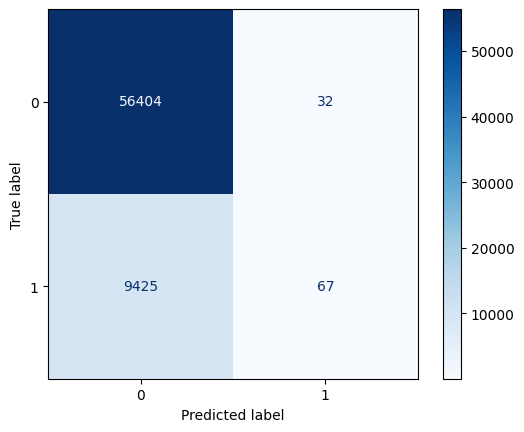

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, get_scorer, make_scorer
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils import sensitivity_score, specificity_score

# Predict on the test data
test_predictions = test_data['predicted_top20']

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
sensitivity_score = sensitivity_score(test_labels, test_predictions)
specificity_score = specificity_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
roc_auc = roc_auc_score(test_labels, test_predictions)
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity_score}")
print(f"Specificity: {specificity_score}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()
